In [1]:
!pip install transformers opencv-python scikit-learn matplotlib pandas pillow


In [2]:
from google.colab import files

uploaded = files.upload()


Saving 7295923-uhd_2160_4096_30fps.mp4 to 7295923-uhd_2160_4096_30fps.mp4
Saving 15118509_2562_1440_60fps.mp4 to 15118509_2562_1440_60fps.mp4
Saving 3249904-uhd_3840_2160_25fps.mp4 to 3249904-uhd_3840_2160_25fps.mp4


In [3]:
import os

video_files = [f for f in os.listdir() if f.endswith(".mp4")]
video_files


['3249904-uhd_3840_2160_25fps.mp4',
 '7295923-uhd_2160_4096_30fps.mp4',
 '15118509_2562_1440_60fps.mp4']

In [4]:
import os

os.makedirs("frames", exist_ok=True)
os.makedirs("embeddings", exist_ok=True)


In [5]:
import cv2
import pandas as pd

FRAME_EVERY_SEC = 2
rows = []

for vid in video_files:
    cap = cv2.VideoCapture(vid)
    fps = cap.get(cv2.CAP_PROP_FPS)

    count = 0
    idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if count % int(fps * FRAME_EVERY_SEC) == 0:
            name = f"{vid}_{idx}.jpg"
            path = os.path.join("frames", name)
            cv2.imwrite(path, frame)

            rows.append({
                "video": vid,
                "frame_id": idx,
                "path": path
            })

            idx += 1

        count += 1

    cap.release()

df = pd.DataFrame(rows)
df.to_csv("metadata.csv", index=False)

print("Total frames:", len(df))
df.head()


Total frames: 18


,video,frame_id,path
0,3249904-uhd_3840_2160_25fps.mp4,0,frames/3249904-uhd_3840_2160_25fps.mp4_0.jpg
1,3249904-uhd_3840_2160_25fps.mp4,1,frames/3249904-uhd_3840_2160_25fps.mp4_1.jpg
2,3249904-uhd_3840_2160_25fps.mp4,2,frames/3249904-uhd_3840_2160_25fps.mp4_2.jpg
3,3249904-uhd_3840_2160_25fps.mp4,3,frames/3249904-uhd_3840_2160_25fps.mp4_3.jpg
4,7295923-uhd_2160_4096_30fps.mp4,0,frames/7295923-uhd_2160_4096_30fps.mp4_0.jpg


In [9]:
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

df = pd.read_csv("metadata.csv")

embeddings = []

for p in df["path"]:
    img = Image.open(p).convert("RGB")
    inputs = processor(images=img, return_tensors="pt").to(device)

    with torch.no_grad():
        emb = model.get_image_features(**inputs)
        emb = emb if isinstance(emb, torch.Tensor) else emb.pooler_output

    embeddings.append(emb.cpu().numpy()[0])

embeddings = np.array(embeddings)

assert not np.isnan(embeddings).any()
print("Embedding shape:", embeddings.shape)

np.save("embeddings/frame_embeddings.npy", embeddings)


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding shape: (18, 512)


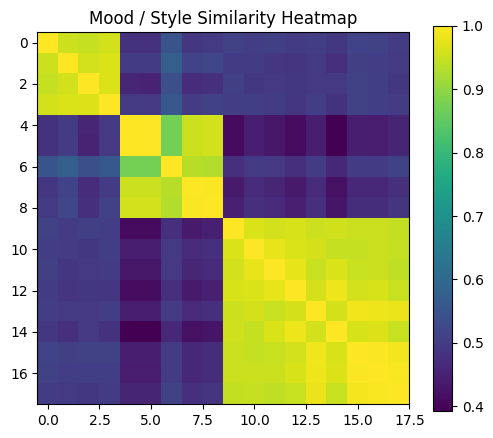

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

emb = np.load("embeddings/frame_embeddings.npy")

sim = cosine_similarity(emb)

plt.figure(figsize=(6,5))
plt.imshow(sim)
plt.colorbar()
plt.title("Mood / Style Similarity Heatmap")
plt.show()


In [11]:
for q in [0, len(df)//2, len(df)-1]:
    scores = sim[q]
    top = scores.argsort()[-6:][::-1]

    print(f"\nQuery Frame {q}")
    for i in top:
        print(i, df.iloc[i]["path"], round(scores[i], 3))



Query Frame 0
0 frames/3249904-uhd_3840_2160_25fps.mp4_0.jpg 1.0
3 frames/3249904-uhd_3840_2160_25fps.mp4_3.jpg 0.958
1 frames/3249904-uhd_3840_2160_25fps.mp4_1.jpg 0.954
2 frames/3249904-uhd_3840_2160_25fps.mp4_2.jpg 0.947
6 frames/7295923-uhd_2160_4096_30fps.mp4_2.jpg 0.552
15 frames/15118509_2562_1440_60fps.mp4_6.jpg 0.515

Query Frame 9
9 frames/15118509_2562_1440_60fps.mp4_0.jpg 1.0
10 frames/15118509_2562_1440_60fps.mp4_1.jpg 0.966
12 frames/15118509_2562_1440_60fps.mp4_3.jpg 0.963
11 frames/15118509_2562_1440_60fps.mp4_2.jpg 0.959
14 frames/15118509_2562_1440_60fps.mp4_5.jpg 0.956
13 frames/15118509_2562_1440_60fps.mp4_4.jpg 0.953

Query Frame 17
17 frames/15118509_2562_1440_60fps.mp4_8.jpg 1.0
16 frames/15118509_2562_1440_60fps.mp4_7.jpg 0.994
15 frames/15118509_2562_1440_60fps.mp4_6.jpg 0.989
13 frames/15118509_2562_1440_60fps.mp4_4.jpg 0.982
14 frames/15118509_2562_1440_60fps.mp4_5.jpg 0.95
12 frames/15118509_2562_1440_60fps.mp4_3.jpg 0.95


In [14]:
# Same image twice should give same embedding
test_img = Image.open(df.iloc[0]["path"]).convert("RGB")
inputs = processor(images=test_img, return_tensors="pt").to(device)

with torch.no_grad():
    e1 = model.get_image_features(**inputs)
    e1 = e1 if isinstance(e1, torch.Tensor) else e1.pooler_output

    e2 = model.get_image_features(**inputs)
    e2 = e2 if isinstance(e2, torch.Tensor) else e2.pooler_output

assert torch.allclose(e1, e2)
print("Identical frame test passed.")



Identical frame test passed.


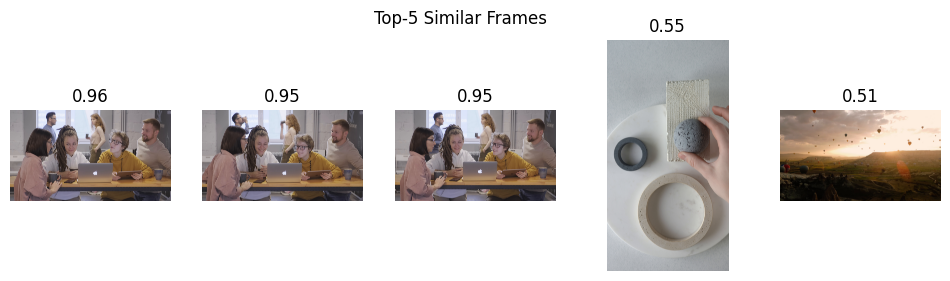

In [15]:
from matplotlib import pyplot as plt
from PIL import Image

query = 0
scores = sim[query]
top = scores.argsort()[-6:][::-1][1:]

plt.figure(figsize=(12,3))
for i, idx in enumerate(top[:5]):
    img = Image.open(df.iloc[idx]["path"])
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(round(scores[idx],2))
plt.suptitle("Top-5 Similar Frames")
plt.show()
